In [1]:
!pip install --upgrade scipy

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix
import scipy
from scipy import io

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
batch_size = 64
output_nodes = 2
learning_rate = 0.001

In [5]:
train_data_path = r"/kaggle/input/deltadoubledelta-all-feat-add/delta,DoubleDelta/MFCC/Delta/train"
validation_data_path =r"/kaggle/input/deltadoubledelta-all-feat-add/delta,DoubleDelta/MFCC/Delta/dev"
test_data_path = r"/kaggle/input/deltadoubledelta-all-feat-add/delta,DoubleDelta/MFCC/Delta/test"

In [6]:
# # ResNet50
# class PtDataset(Dataset):
#     def __init__(self, directory):
#         self.directory = directory
#         self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
#         self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
#         self.files = []
#         for c in self.classes:
#             c_dir = os.path.join(directory, c)
#             c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir)]
#             self.files.extend(c_files)
#         random.shuffle(self.files)
        
#     def __len__(self):
#         return len(self.files)
    
#     # Assuming mono audio data
#     def __getitem__(self, idx):
#         filepath, label = self.files[idx]
#         try:
#             mat_vals = scipy.io.loadmat(filepath)
#             data = mat_vals['final']
#             data = data.T
#             max_len = 750

#             if (max_len > data.shape[0]):
#                 pad_width = max_len - data.shape[0]
#                 data = np.pad(data, pad_width=((0, pad_width), (0, 0)), mode='constant')
#             else:
#                 data = data[:max_len, :]

#             # Reshape data to (1, 750, 20) for mono audio
#             data = data[np.newaxis, :, :]

#         except Exception as e:
#             print(f"Error loading file {filepath}: {str(e)}")
#             return None

#         return data, label


In [7]:
class PtDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.files = []
        for c in self.classes:
            c_dir = os.path.join(directory, c)
            c_files = [(os.path.join(c_dir, f), self.class_to_idx[c]) for f in os.listdir(c_dir)]
            self.files.extend(c_files)
        random.shuffle(self.files)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath, label = self.files[idx]
        try:
            mat_vals = scipy.io.loadmat(filepath)
            data = mat_vals['final']
#             data = data.T
            max_len=750
            if (max_len > data.shape[0]):
                pad_width = max_len - data.shape[0]
                data = np.pad(data, pad_width=((0, pad_width),(0,0)), mode='constant')
            else:
                data = data[:max_len, :]
        except Exception as e:
            print(f"Error loading file {filepath}: {str(e)}")
            return None
        return data, label

In [8]:
train_dataset = PtDataset(train_data_path)
test_dataset = PtDataset(test_data_path)
val_dataset = PtDataset(validation_data_path)

In [9]:
class PtDataLoader(DataLoader):
    def __init__(self, directory, batch_size, shuffle=True):
        dataset = PtDataset(directory)
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

In [10]:
train_dataloader = PtDataLoader(directory=train_data_path, batch_size=batch_size)
test_dataloader = PtDataLoader(directory=test_data_path, batch_size=batch_size)
val_dataloader = PtDataLoader(directory=validation_data_path, batch_size=batch_size)

In [11]:
train_count = len(train_dataset) 
test_count = len(test_dataset)
val_count = len(val_dataset)

In [12]:
print(train_count)
print(test_count)
print(val_count)

53866
4634
10798


In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(p=drop_amount)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Explicitly specify the data type for initial hidden state tensors
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype).to(device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=x.dtype).to(device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
drop_amount = 0.255

class BiGRUAudioClassifier(nn.Module):
    def __init__(self,input_size, num_classes, hidden_units, num_layers):
        super(BiGRUAudioClassifier, self).__init__()
        self.input_size = input_size 
        self.num_classes = num_classes
        self.hidden_units = hidden_units
        self.num_layers = num_layers

        self.bigru = nn.GRU(input_size=input_size, hidden_size=hidden_units, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=drop_amount)
        # self.fc = nn.Linear(hidden_units, num_classes)
        self.fc = nn.Linear(hidden_units * 2, num_classes)

    def forward(self, x):
        # x: (batch_size, sequence_length, num_features)

        # Pass the input through the bi-GRU layers
        output, _ = self.bigru(x)
        output = self.dropout(output)
        # Extract the last hidden state (concatenate forward and backward hidden states)
        last_hidden_state = torch.cat((output[:, -1, :self.hidden_units], output[:, 0, self.hidden_units:]), dim=1)
        # Apply the fully connected layer for classification
        output = self.fc(last_hidden_state)

        return output

In [15]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F

In [16]:
# Define the parameters
input_size = 20
hidden_size = 256
num_layers = 2
num_classes = 2
# drop_amount = 0.25  # You can choose an appropriate dropout rate

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.to(device, dtype=torch.double)


LSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
print(model)

LSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [20]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os, pathlib, glob, random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset
from transformers.models.whisper.modeling_whisper import WhisperModel, WhisperEncoder
from transformers.models.whisper.configuration_whisper import WhisperConfig
from typing import Optional, Tuple, Union
import torch
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import os, glob, pickle
import scipy.io as sio
from tqdm import tqdm
import multiprocessing as mp 
import torch.optim as optim

In [21]:
#Model training and testing 
n_total_steps = len(train_dataloader) # n_total_steps * batch size will give total number of training files (consider that last batch may not be fully filled)
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc=0
num_epochs = 15
pred_labels =[]
act_labels = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for batch_idx, (images,labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1)
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    
    # Validation on Validation dataset
    model.eval()
    val_accuracy=0.0
    pred = []
    lab = []
    
    for i, (images,labels) in enumerate(val_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1) 
#         print(i,images.shape)
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
        pred.extend(prediction.tolist())
        lab.extend(labels.tolist())
    
    val_accuracy=val_accuracy/val_count
    val_accuracy_list.append(val_accuracy)
    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        max_acc = val_accuracy
        torch.save(model,"best_accuracy_model_LSTM.pth")
    print('Epoch : '+str(epoch+1)+'/'+str(num_epochs)+'   Train Loss : '+str(train_loss)+'   Train Accuracy : '+str(train_accuracy)+'   Test Accuracy : '+str(val_accuracy))
print(max_acc)   
print('Finished Training and Testing')

Epoch : 1/15   Train Loss : tensor(0.6972, dtype=torch.float64)   Train Accuracy : 0.4993131103107712   Test Accuracy : 0.49990739025745506
Epoch : 2/15   Train Loss : tensor(0.6941, dtype=torch.float64)   Train Accuracy : 0.49756803920840603   Test Accuracy : 0.5000926097425449
Epoch : 3/15   Train Loss : tensor(0.6932, dtype=torch.float64)   Train Accuracy : 0.49701110162254486   Test Accuracy : 0.49990739025745506
Epoch : 4/15   Train Loss : tensor(0.6932, dtype=torch.float64)   Train Accuracy : 0.49988861248282773   Test Accuracy : 0.5000926097425449
Epoch : 5/15   Train Loss : tensor(0.6932, dtype=torch.float64)   Train Accuracy : 0.49875617272490996   Test Accuracy : 0.49990739025745506
Epoch : 6/15   Train Loss : tensor(0.6932, dtype=torch.float64)   Train Accuracy : 0.5010767459993317   Test Accuracy : 0.49990739025745506
Epoch : 7/15   Train Loss : tensor(0.6940, dtype=torch.float64)   Train Accuracy : 0.5025619128949615   Test Accuracy : 0.5000926097425449
Epoch : 8/15   Trai

In [22]:
# Load the best model
best_model = torch.load("best_accuracy_model_LSTM.pth")

# Put the best_model in evaluation mode
best_model.eval()

# Initialize variables to store results
testing_accuracy = 0.0
pred_labels = []
act_labels = []

# Pass validation data through the best model
for i, (images, labels) in enumerate(test_dataloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    
    outputs = best_model(images)
    _, prediction = torch.max(outputs.data, 1)
    
    testing_accuracy += int(torch.sum(prediction == labels.data))
    
    pred_labels.extend(prediction.tolist())
    act_labels.extend(labels.tolist())

# Calculate validation accuracy
testing_accuracy = testing_accuracy / len(test_dataloader.dataset)

# Print the validation accuracy
print("testing Accuracy:", testing_accuracy)
# train Accuracy: 0.9726729291204099
# Validation Accuracy: 0.9680496388220041
# test Accuracy: 0.9512300388433319

testing Accuracy: 0.48856279671989644


In [23]:
print(model)

LSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


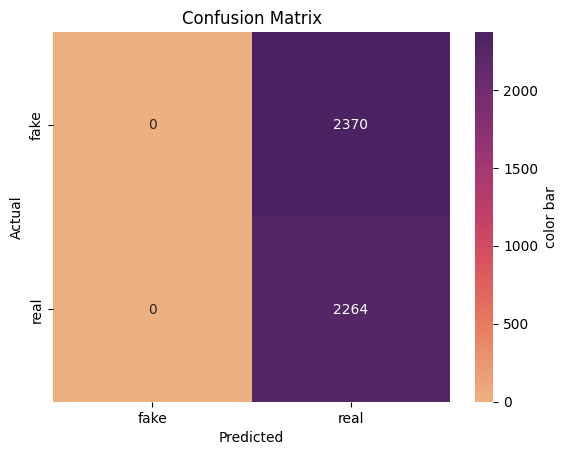

F1 Score :  0.32821107567410845


In [24]:
# Calculate the confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(act_labels, pred_labels)
# Plot confusion matrix heat map
sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g", 
            cbar_kws={"label":"color bar"},
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix_LSTM.png")
plt.show()
from sklearn.metrics import f1_score
f1_score = f1_score(pred_labels, act_labels, average='macro')
print('F1 Score : ', f1_score)


In [25]:
# torch.save(model,'MGDCC_LSTMClassifier_01_01.pth')

In [26]:
# BiLSTM

In [27]:
drop_amount = 0.255

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=drop_amount)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device=x.device, dtype=torch.double)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device=x.device, dtype=torch.double)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        # Extract the output of the last time step from both directions
        last_hidden_state = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)
        output = self.fc(last_hidden_state)
        return output

In [28]:
batch_size = 64
output_nodes = 2
learning_rate = 0.0001

In [29]:
model = BiLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
model.to(device, dtype=torch.double)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

BiLSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [30]:
print(model)

BiLSTMClassifier(
  (lstm): LSTM(20, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.255, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


In [31]:
#Model training and testing 
n_total_steps = len(train_dataloader) # n_total_steps * batch size will give total number of training files (consider that last batch may not be fully filled)
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
max_acc=0
num_epochs = 15
pred_labels =[]
act_labels = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for batch_idx, (images,labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1)
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    
    # Validation on Validation dataset
    model.eval()
    val_accuracy=0.0
    pred = []
    lab = []
    
    for i, (images,labels) in enumerate(val_dataloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        ##images = images.unsqueeze(1) 
#         print(i,images.shape)
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
        pred.extend(prediction.tolist())
        lab.extend(labels.tolist())
    
    val_accuracy=val_accuracy/val_count
    val_accuracy_list.append(val_accuracy)
    if max_acc < val_accuracy:
        max_acc = val_accuracy
        pred_labels = pred
        actual_labels = lab
        max_acc = val_accuracy
        torch.save(model,"best_accuracy_model_BiLSTM.pth")
    print('Epoch : '+str(epoch+1)+'/'+str(num_epochs)+'   Train Loss : '+str(train_loss)+'   Train Accuracy : '+str(train_accuracy)+'   Test Accuracy : '+str(val_accuracy))
print(max_acc)   
print('Finished Training and Testing')

Epoch : 1/15   Train Loss : tensor(0.4742, dtype=torch.float64)   Train Accuracy : 0.7606096610106561   Test Accuracy : 0.8696980922393036
Epoch : 2/15   Train Loss : tensor(0.3130, dtype=torch.float64)   Train Accuracy : 0.8712731593212787   Test Accuracy : 0.8852565289868494
Epoch : 3/15   Train Loss : tensor(0.2628, dtype=torch.float64)   Train Accuracy : 0.8962053985816656   Test Accuracy : 0.8952583811817003
Epoch : 4/15   Train Loss : tensor(0.2491, dtype=torch.float64)   Train Accuracy : 0.8999740095793265   Test Accuracy : 0.8918318207075384
Epoch : 5/15   Train Loss : tensor(0.2084, dtype=torch.float64)   Train Accuracy : 0.9169234767757026   Test Accuracy : 0.9287831079829598
Epoch : 6/15   Train Loss : tensor(0.1823, dtype=torch.float64)   Train Accuracy : 0.9280993576653176   Test Accuracy : 0.9386923504352658
Epoch : 7/15   Train Loss : tensor(0.1747, dtype=torch.float64)   Train Accuracy : 0.9324249062488397   Test Accuracy : 0.9326727171698462
Epoch : 8/15   Train Loss :

In [32]:
# Load the best model
best_model = torch.load("best_accuracy_model_BiLSTM.pth")

# Put the best_model in evaluation mode
best_model.eval()

# Initialize variables to store results
testing_accuracy = 0.0
pred_labels = []
act_labels = []

# Pass validation data through the best model
for i, (images, labels) in enumerate(test_dataloader):
    if torch.cuda.is_available():
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
    
    outputs = best_model(images)
    _, prediction = torch.max(outputs.data, 1)
    
    testing_accuracy += int(torch.sum(prediction == labels.data))
    
    pred_labels.extend(prediction.tolist())
    act_labels.extend(labels.tolist())

# Calculate validation accuracy
testing_accuracy = testing_accuracy / len(test_dataloader.dataset)

# Print the validation accuracy
print("testing Accuracy:", testing_accuracy)

testing Accuracy: 0.7384548985757445


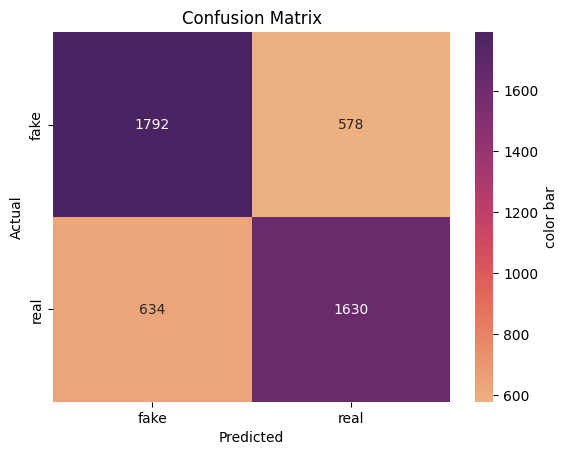

F1 Score :  0.7381348649217221


In [33]:
# Calculate the confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(act_labels, pred_labels)
# Plot confusion matrix heat map
sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g", 
            cbar_kws={"label":"color bar"},
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrix_BiLSTM.png")
plt.show()
from sklearn.metrics import f1_score
f1_score = f1_score(pred_labels, act_labels, average='macro')
print('F1 Score : ', f1_score)


In [34]:
# torch.save(model,'MGDCC_BiLSTMClassifier_01_01.pth')

In [35]:
# ResNet50
# import torch
# import torch.nn as nn


# def conv3x3(in_channels, out_channels, stride=1):
#     """3x3 convolution with padding"""
#     return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(Bottleneck, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)

#         return out


# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes=1000):
#         super(ResNet, self).__init__()

#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# #         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, out_channels, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.in_channels != out_channels * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels * block.expansion),
#             )

#         layers = [block(self.in_channels, out_channels, stride, downsample)]
#         self.in_channels = out_channels * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.in_channels, out_channels))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x


# # ResNet-50
# def resnet50(num_classes=2):
#     return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


In [36]:
# model = resnet50()
# model.to(device, dtype=torch.double)
# loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# print(model)

In [37]:
# torch.save(model,'MGDCC_ResNet50_0_0001.pth')

In [38]:
# # Calculate the confusion matrix
# import seaborn as sns
# conf_mat = confusion_matrix(act_labels, pred_labels)
# # Plot confusion matrix heat map
# sns.heatmap(conf_mat, cmap="flare",annot=True, fmt = "g", 
#             cbar_kws={"label":"color bar"},
#             xticklabels=train_dataset.classes,
#             yticklabels=train_dataset.classes)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.savefig("ConfusionMatrix.png")
# plt.show()
# from sklearn.metrics import f1_score
# f1_score = f1_score(pred_labels, act_labels, average='macro')
# print('F1 Score : ', f1_score)